# Analysis of Review Time vs Retention and Rating

This notebook explores how real review durations (ms) correlate with FSRS-estimated retrievability and the ratings provided by the user.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# Add src to path
sys.path.append(os.path.abspath("../src"))

from fsrs import Card, Scheduler
from statsmodels.miscmodels.ordinal_model import OrderedModel

import fsrs_engine
from anki_utils import get_review_history_stats, infer_review_weights, load_anki_history
from simulate_fsrs import RustOptimizer, run_simulation
from simulation_config import SeededData, SimulationConfig

/home/acbraith/projects/fsrs_experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Shared configuration
REPEATS = int(os.getenv("REPEATS", "5"))
N_DAYS = int(os.getenv("N_DAYS", "180"))
SEED_HISTORY = os.getenv("ANKI_COLLECTION", "../collection.anki2")
DECK_CONFIG = os.getenv("DECK_CONFIG", "GoProblems")

if SEED_HISTORY and not os.path.exists(SEED_HISTORY):
    SEED_HISTORY = None

## Data Loading and FSRS Fitting

In [3]:
print(f"Loading history for {DECK_CONFIG}...")
logs, last_rev = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)
flat_logs = [log for card_logs in logs.values() for log in card_logs]

print(f"Fitting FSRS-6 parameters on {len(flat_logs)} reviews...")
optimizer = RustOptimizer(flat_logs)
fitted_params = tuple(optimizer.compute_optimal_parameters())
print(f"Fitted params: {fitted_params}")

# Pre-calculate card states for seeding
print("Pre-calculating initial card states (replaying history)...")
scheduler = Scheduler(parameters=fitted_params)
true_cards = {}
sys_cards = {}

for cid, card_logs in logs.items():
    true_cards[cid] = scheduler.reschedule_card(Card(card_id=cid), card_logs)
    sys_cards[cid] = scheduler.reschedule_card(Card(card_id=cid), card_logs)

seeded_data = SeededData(
    logs=logs,
    last_rev=last_rev,
    true_cards=true_cards,
    sys_cards=sys_cards,
)
print("Seeding complete.")

Loading history for GoProblems...
Anki database version 18 detected.
Querying reviews for 2 matching decks...
Successfully loaded 10645 reviews for 1613 cards.
Review date range: 2025-06-23 to 2026-02-03
Fitting FSRS-6 parameters on 10645 reviews...
Fitted params: (0.004457816481590271, 0.004457816481590271, 0.3856838047504425, 13.134493827819824, 6.413300037384033, 0.8334000110626221, 3.019399881362915, 0.0010000000474974513, 1.8722000122070312, 0.16660000383853912, 0.7960000038146973, 1.4835000038146973, 0.061400000005960464, 0.2628999948501587, 1.648300051689148, 0.6014000177383423, 1.8729000091552734, 0.5425000190734863, 0.09120000153779984, 0.0658000037074089, 0.1542000025510788)
Pre-calculating initial card states (replaying history)...
Seeding complete.


In [4]:
stats = get_review_history_stats(logs, fitted_params)
df = pd.DataFrame(stats)
df = df.dropna(subset=["duration"])
assert (df["duration"] == 0).sum() == 0
# Convert duration from ms to seconds for easier reading
df["duration_sec"] = df["duration"] / 1000.0
df["is_new_card"] = df["stability"] == 0
mean_duration_sec = df["duration_sec"].mean()
df.head()

,card_id,retention,rating,duration,stability,difficulty,elapsed_days,duration_sec,is_new_card
0,1750687785502,0.667700,3,21129,0.000000,3.185642,0.000000,21.129,True
1,1750687785502,1.000000,3,1325,0.385684,2.118104,0.000015,1.325,False
2,1750687785502,0.832938,3,25095,0.431464,2.111214,1.611483,25.095,False
3,1750687785502,0.846107,3,17764,4.511625,2.104331,9.852340,17.764,False
4,1750687785502,0.875923,3,10139,30.971528,2.097455,43.475696,10.139,False


In [5]:
from anki_utils import (
    calculate_expected_d0,
)

# Baseline features for new cards (matches get_review_history_stats)
weights = infer_review_weights(logs)
w_first = weights.first
prob_first_success = 1.0 - w_first[0]
expected_d0 = calculate_expected_d0(w_first, fitted_params)

## Review Time Estimation
Review time is not constant; it can be more expensive to review certain types of cards.

We fit a linear model to give us more accurate estimates of review time. This will use the card state and FSRS model output (i.e. new/review, stability, difficulty and retention) alongside the rating given to estimate review time.

We use cross-validation and an L1 penalty term to check if any features are not useful for generalisably forecasting review time.

Optimal Alpha: 0.004358
R-squared: 0.1747
--- Coefficients ---
is_new_card: -0.0153
retention: -0.7948
rating: -4.1804
stability: -0.3871
difficulty: 0.5454


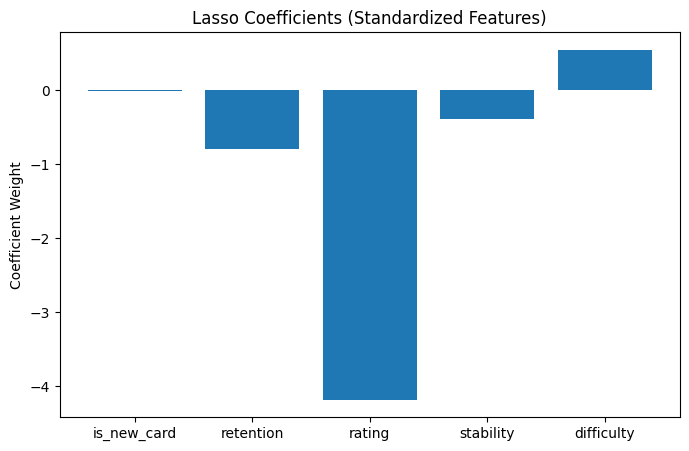

In [6]:
# Prepare features and target
features = ["is_new_card", "retention", "rating", "stability", "difficulty"]
target = "duration_sec"
X = df[features].values
y = df[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with Cross-Validation to select alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

print(f"Optimal Alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, y):.4f}")
print("--- Coefficients ---")
for feat, coef in zip(features, lasso.coef_, strict=False):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(features, lasso.coef_)
plt.title("Lasso Coefficients (Standardized Features)")
plt.ylabel("Coefficient Weight")
plt.show()

### Statistical Significance of Review Time Factors
While the Lasso model above shows the weight of each factor, we can use Ordinary Least Squares (OLS) to determine the "statistical significance" (p-values). 

**For non-experts:** A p-value (P>|t|) less than 0.05 indicates that we are 95% confident the factor has a real effect on review time and isn't just random noise.

In [7]:
import statsmodels.api as sm

# Add a constant (intercept) to the features
X_ols = sm.add_constant(X_scaled)
ols_time = sm.OLS(y, X_ols).fit()

print(ols_time.summary(xname=["const"] + features))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     450.4
Date:                Wed, 04 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:28:53   Log-Likelihood:                -39306.
No. Observations:               10645   AIC:                         7.862e+04
Df Residuals:                   10639   BIC:                         7.867e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9058      0.094    137.045      

#### Visualizing the Size of Impact
To make this intuitive, let's look at how much the predicted review time changes for different types of reviews compared to the **Constant Baseline** (the average of all reviews).

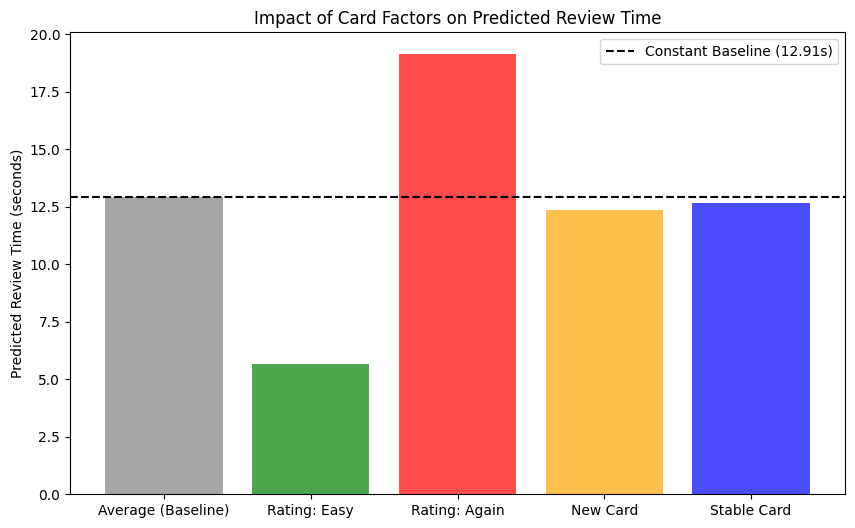

An 'Easy' review is predicted to take 5.67s, while an 'Again' review takes 19.12s.


In [8]:
mean_series = df[features].mean()


def create_scenario(**kwargs):
    s = mean_series.copy()
    for k, v in kwargs.items():
        s[k] = v
    return s.values


scenarios = {
    "Average (Baseline)": mean_series.values,
    "Rating: Easy": create_scenario(rating=4),
    "Rating: Again": create_scenario(rating=1),
    "New Card": create_scenario(is_new_card=1, stability=0, difficulty=expected_d0),
    "Stable Card": create_scenario(stability=df["stability"].quantile(0.9)),
}

scenario_names = list(scenarios.keys())
scenario_features = np.array(list(scenarios.values()))
scenario_features_scaled = scaler.transform(scenario_features)
predictions = lasso.predict(scenario_features_scaled)

plt.figure(figsize=(10, 6))
colors = ["gray", "green", "red", "orange", "blue"]
plt.bar(scenario_names, predictions, color=colors, alpha=0.7)
plt.axhline(
    mean_duration_sec,
    color="black",
    linestyle="--",
    label=f"Constant Baseline ({mean_duration_sec:.2f}s)",
)

plt.ylabel("Predicted Review Time (seconds)")
plt.title("Impact of Card Factors on Predicted Review Time")
plt.legend()
plt.show()

print(
    f"An 'Easy' review is predicted to take {predictions[1]:.2f}s, "
    f"while an 'Again' review takes {predictions[2]:.2f}s."
)

## Grade Prediction Model

The FSRS model estimates success/failure of a review. However, success can have various "degrees" (i.e. rating hard, good, easy). Current simulations assume this distribution is uniform across all review cards regardless of card specifics.

That is not true. We use an `OrderedModel` to determine the probability distribution over rating (Hard, Good, Easy) for a given review given that a review was successful (retrieved).

At simulation time we can sample from the distrubiton given by this `OrderedModel` rather than assuming the same probability distrubiton for all reviews.

In [14]:
# Filter for successful reviews (Rating > 1)
df_success = df[df["rating"] > 1].copy()

# OrderedModel needs at least 2 unique categories and enough data
if len(df_success) >= 10 and df_success["rating"].nunique() > 1:
    # Features for grade prediction
    grade_features = ["is_new_card", "retention", "stability", "difficulty"]
    X_grade = df_success[grade_features].values
    y_grade = df_success["rating"].values

    # Standardize features
    scaler_grade = StandardScaler()
    X_grade_scaled = scaler_grade.fit_transform(X_grade)

    # Fit OrderedModel
    try:
        mod_prob = OrderedModel(y_grade, X_grade_scaled, distr="probit")
        res_prob = mod_prob.fit(method="bfgs", disp=False)
        print(res_prob.summary())
        HAS_GRADE_MODEL = True
    except Exception as e:
        print(f"Failed to fit OrderedModel: {e}")
        HAS_GRADE_MODEL = False
else:
    print("Insufficient data for OrderedModel, falling back to simple weights.")
    HAS_GRADE_MODEL = False


def predict_grades_batch(features_list, weights, count):
    if HAS_GRADE_MODEL and len(features_list) > 0:
        x_features = np.array(features_list)
        x_scaled = scaler_grade.transform(x_features)
        probs_all = res_prob.predict(x_scaled)

        # Vectorized weighted random choice
        # cumsum along axis 1 gives cumulative probabilities
        # we compare against random draws
        cum_probs = probs_all.cumsum(axis=1)
        r = np.random.rand(len(probs_all), 1)
        # Count how many thresholds we haven't crossed yet.
        # This logic finds the index where r falls.
        # Example: probs=[0.2, 0.5, 0.3] -> cum=[0.2, 0.7, 1.0]
        # r=0.1 -> <0.2, <0.7, <1.0 -> sum=3? No.
        # We want index i such that cum[i-1] <= r < cum[i]
        # Standard trick: (cum_probs < r).sum(axis=1)
        choice_indices = (cum_probs < r).sum(axis=1)
        # Clip to ensure valid indices (just in case of float precision issues)
        choice_indices = np.minimum(choice_indices, len(res_prob.model.labels) - 1)

        return res_prob.model.labels[choice_indices].tolist()
    else:
        # Fallback to simple success weights
        return np.random.choice([2, 3, 4], size=count, p=weights.success).tolist()

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -1779.3
Model:                   OrderedModel   AIC:                             3571.
Method:            Maximum Likelihood   BIC:                             3612.
Date:                Wed, 04 Feb 2026                                         
Time:                        11:45:35                                         
No. Observations:                7434                                         
Df Residuals:                    7428                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1555      0.026      5.926      0.000       0.104       0.207
x2             0.1501      0.024      6.317      0.0

### Statistical Significance of Grade Distribution
The `OrderedModel` summary above shows the significance of each factor on the grade given (for successful reviews).

To visualize this, let's look at how the predicted probability of each grade (Hard, Good, Easy) changes as **Retention** increases, while keeping other factors constant.

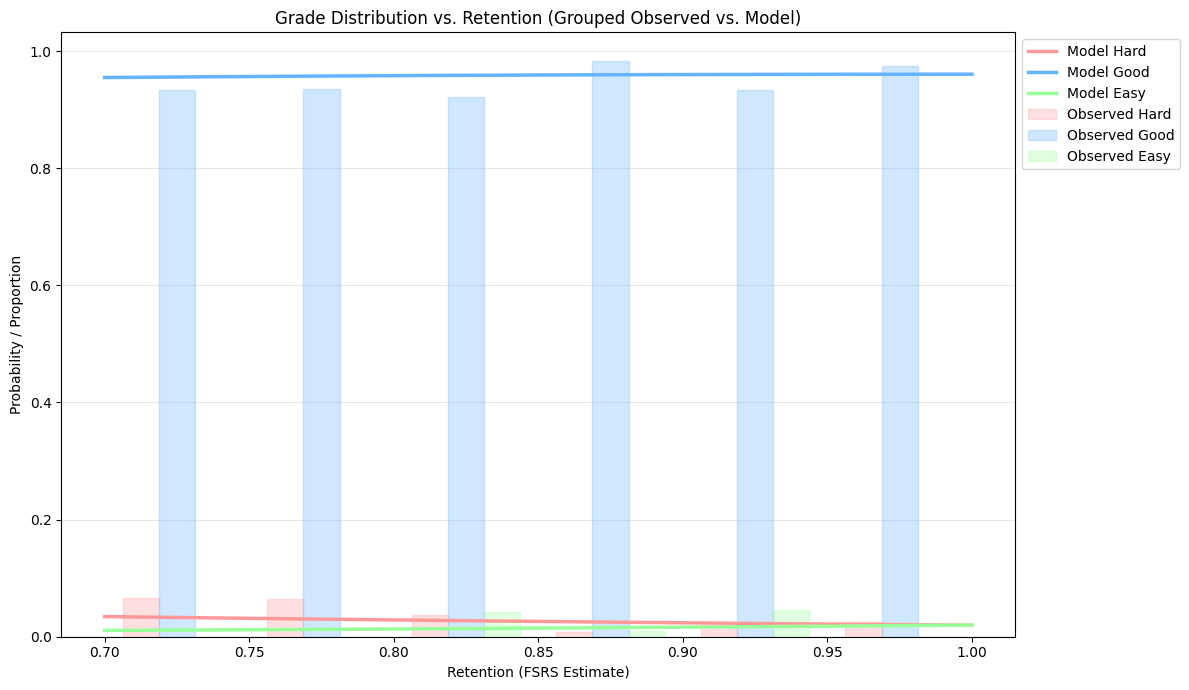

In [15]:
if HAS_GRADE_MODEL:
    # 1. Calculate Observed Proportions (Underlay)
    # Create buckets for retention (e.g., 6 buckets between 0.7 and 1.0)
    num_buckets = 6
    df_success["ret_bucket"] = pd.cut(
        df_success["retention"], bins=np.linspace(0.7, 1.0, num_buckets + 1)
    )
    obs_counts = (
        df_success.groupby(["ret_bucket", "rating"], observed=False)
        .size()
        .unstack(fill_value=0)
    )
    obs_props = obs_counts.div(obs_counts.sum(axis=1), axis=0)
    bin_mids = np.array([b.mid for b in obs_props.index])

    # 2. Model Prediction over range
    mean_vals = X_grade.mean(axis=0)
    ret_range = np.linspace(0.7, 1.0, 100)

    probs_list = []
    for r in ret_range:
        feat = mean_vals.copy()
        feat[1] = r
        feat_scaled = scaler_grade.transform([feat])
        probs = res_prob.predict(feat_scaled)[0]
        probs_list.append(probs)

    probs_arr = np.array(probs_list)
    labels = res_prob.model.labels  # [2, 3, 4]
    label_names = {2: "Hard", 3: "Good", 4: "Easy"}
    colors = ["#ff9999", "#66b3ff", "#99ff99"]  # Red, Blue, Greenish

    plt.figure(figsize=(12, 7))

    # 3. Plot Grouped Bars for Observed Proportions
    # Total width of one bucket in the plot is roughly (1.0-0.7)/num_buckets = 0.05
    bucket_width = (1.0 - 0.7) / num_buckets
    bar_width = bucket_width / 4
    offsets = [-bar_width, 0, bar_width]

    for i, label in enumerate(labels):
        plt.bar(
            bin_mids + offsets[i],
            obs_props[label],
            width=bar_width,
            alpha=0.3,
            color=colors[i],
            edgecolor=colors[i],
            label=f"Observed {label_names.get(label, label)}",
        )

    # 4. Plot Model Prediction Lines
    for i, label in enumerate(labels):
        plt.plot(
            ret_range,
            probs_arr[:, i],
            color=colors[i],
            linewidth=2.5,
            label=f"Model {label_names.get(label, label)}",
        )

    plt.xlabel("Retention (FSRS Estimate)")
    plt.ylabel("Probability / Proportion")
    plt.title("Grade Distribution vs. Retention (Grouped Observed vs. Model)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Grade model not available for visualization.")

## Improved Optimal Retention
Current optimal retention assumes all reviews are equal. We can now estimate the true cost (in time) of a review.

Let's run simulations using these estimates for review times based on card state at time of review to see the impact this has on optimal retention.

Note these simulations are also applying the post-processing discussed in the [Optimal Retention notebook](notebooks/Optimal_Retention.ipynb).

In [16]:
def lasso_time_estimator(
    stabilities, difficulties, day_idx, last_reviews, params, ratings
):
    # Vectorized retrievability
    new_mask = last_reviews == -1
    rev_mask = ~new_mask

    rets = np.zeros(len(stabilities))
    if np.any(rev_mask):
        rets[rev_mask] = fsrs_engine.predict_retrievability(
            stabilities[rev_mask], day_idx - last_reviews[rev_mask], params
        )
    if np.any(new_mask):
        rets[new_mask] = prob_first_success

    # Prepare feature matrix
    # features = ["is_new_card", "retention", "rating", "stability", "difficulty"]
    features_matrix = np.column_stack(
        [
            new_mask.astype(int),
            rets,
            ratings,
            stabilities,
            np.where(new_mask, expected_d0, difficulties),
        ]
    )

    features_scaled = scaler.transform(features_matrix)
    pred_secs = lasso.predict(features_scaled)
    return np.maximum(0.5, pred_secs)


lasso_time_estimator._vectorized = True

In [17]:
def advanced_rating_estimator(stabilities, difficulties, day_idx, last_reviews, params):
    count = len(stabilities)
    results = np.zeros(count, dtype=np.int8)

    new_mask = last_reviews == -1
    rev_mask = ~new_mask

    if np.any(new_mask):
        results[new_mask] = np.random.choice(
            [1, 2, 3, 4], size=np.sum(new_mask), p=weights.first
        )

    if np.any(rev_mask):
        n_rev = np.sum(rev_mask)
        # Calculate retrievability
        rets = fsrs_engine.predict_retrievability(
            stabilities[rev_mask], day_idx - last_reviews[rev_mask], params
        )
        success = np.random.random(n_rev) < rets

        results_rev = np.ones(n_rev, dtype=np.int8)
        n_success = np.sum(success)
        if n_success > 0:
            # Build features for success prediction
            # [is_new (0), ret, stability, difficulty]
            success_features = np.column_stack(
                [
                    np.zeros(n_success),
                    rets[success],
                    stabilities[rev_mask][success],
                    difficulties[rev_mask][success],
                ]
            )
            results_rev[success] = predict_grades_batch(
                success_features, weights, n_success
            )

        results[rev_mask] = results_rev

    return results


advanced_rating_estimator._vectorized = True

In [22]:
daily_budget_sec = 10 * 60
retentions = [
    0.1,
    0.3,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.925,
    0.95,
    0.975,
]


def constant_time_estimator(
    stabilities, difficulties, day_idx, last_reviews, params, ratings
):
    return np.full(len(ratings), mean_duration_sec)


constant_time_estimator._vectorized = True

results_constant = []
results_lasso = []
results_advanced = []

for ret in tqdm(retentions, desc="Simulating"):
    # 1. Constant Time Estimator
    config_const = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=constant_time_estimator,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, metrics_const = run_simulation(
        config_const,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_constant.append(metrics_const)

    # 2. Lasso Model Time Estimator (Default Rating)
    config_lasso = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, metrics_lasso = run_simulation(
        config_lasso,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_lasso.append(metrics_lasso)

    # 3. Advanced Estimator (OrderedModel Grade + Lasso Duration)
    config_adv = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        rating_estimator=advanced_rating_estimator,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, metrics_adv = run_simulation(
        config_adv,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_advanced.append(metrics_adv)

Simulating: 100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


In [23]:
# 1. Determine N_max (baseline population size)
max_cards = max(
    m["card_count"] for m in results_lasso + results_constant + results_advanced
)

# 2. Baseline retention for unseen cards
r_baseline = prob_first_success


def get_adjusted_total(metrics_list, max_n, r_base):
    adjusted = []
    for m in metrics_list:
        # Current sum of retention for studied cards
        current_total = m["total_retention"]
        # Add hypothetical retention for cards we "could have" studied
        missing_cards = max_n - m["card_count"]
        # Ensure we don't subtract if a run somehow exceeded the max (unlikely)
        padding = max(0, missing_cards) * r_base
        adjusted.append(current_total + padding)
    return adjusted


adj_results_constant = get_adjusted_total(results_constant, max_cards, r_baseline)
adj_results_lasso = get_adjusted_total(results_lasso, max_cards, r_baseline)
adj_results_advanced = get_adjusted_total(results_advanced, max_cards, r_baseline)

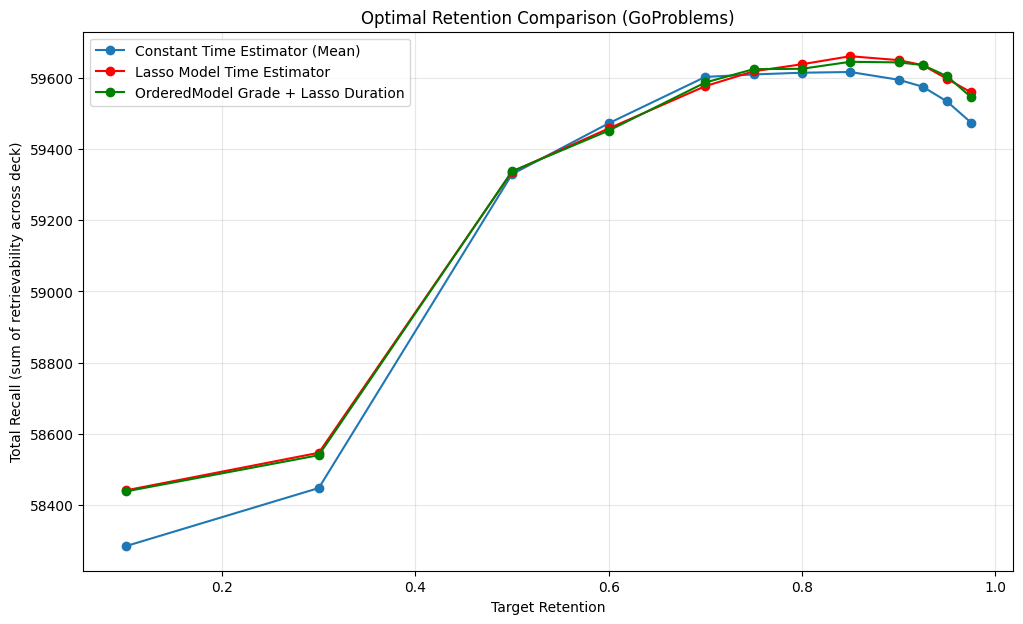

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(
    retentions, adj_results_constant, marker="o", label="Constant Time Estimator (Mean)"
)
plt.plot(
    retentions,
    adj_results_lasso,
    marker="o",
    color="red",
    label="Lasso Model Time Estimator",
)
plt.plot(
    retentions,
    adj_results_advanced,
    marker="o",
    color="green",
    label="OrderedModel Grade + Lasso Duration",
)

plt.title(f"Optimal Retention Comparison ({DECK_CONFIG})")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()